Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

Load and preprocess images

In [ ]:
def load_image(image_path, max_size=512):
    response = requests.get(image_path)
    image = Image.open(BytesIO(response.content)).convert('RGB')
    size = min(max_size, max(image.size))
    transform = transforms.Compose([
        transforms.Resize((max_size, max_size)),  # Ensure same size for content and style
        transforms.ToTensor()
    ])
    return transform(image).unsqueeze(0)

Define content and style loss

    Computes Content Loss using Mean Squared Error (MSE).
    
    Content loss formula:
        L_content = 1/2 * sum((F - P)²)
    where:
        - F: Feature map of the generated image.
        - P: Feature map of the content image.

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, x):
        self.loss = torch.nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self.gram_matrix(target_feature).detach()

    def gram_matrix(self, x):
        b, c, h, w = x.size()
        features = x.view(b * c, h * w)
        G = torch.mm(features, features.t())
        return G.div(b * c * h * w)

    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = torch.nn.functional.mse_loss(G, self.target)
        return x

Build the model and extract features

    Computes Style Loss using Gram Matrix representation.
    
    - Gram matrix represents style by capturing feature correlations.
    - Style loss minimizes the difference between style representation of target and generated images.
    
    Gram Matrix formula:
        G_ij = sum_k (F_ik * F_jk)
    
    Style loss formula:
        L_style = sum((G - A)²)
    where:
        - G: Gram matrix of the generated image.
        - A: Gram matrix of the style image.

    Constructs a VGG19-based model to extract content and style features.

        - Uses pre-trained VGG19 as a feature extractor.
        - Extracts content features from 'conv_4'.
        - Extracts style features from 'conv_1' to 'conv_5'.

In [ ]:
def get_model_and_losses(content_image, style_image):
    cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.eval()
    content_layers = ['conv_4']
    style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    model = nn.Sequential()
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)  # Fix for the relu tuple error
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_image).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target = model(style_image).detach()
            style_loss = StyleLoss(target)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    return model, content_losses, style_losses

Run the style transfer

    Optimizes the input image to minimize content and style loss.

    - Uses Adam optimizer to adjust pixel values.
    - Combines content loss and style loss in the objective function.
    
    Total Loss Formula:
        L_total = L_content + λ * L_style
    where:
        λ = 10^6 (to emphasize style preservation)

In [ ]:
def run_style_transfer(model, content_losses, style_losses, input_image, epochs=300, lr=0.03):
    optimizer = optim.Adam([input_image.requires_grad_()], lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        model(input_image)
        content_score = sum(cl.loss for cl in content_losses)
        style_score = sum(sl.loss for sl in style_losses)
        loss = content_score + 1000000 * style_score
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Content Loss: {content_score.item()}, Style Loss: {style_score.item()}')
    return input_image

Visualize the images

Epoch 0, Content Loss: 0.0, Style Loss: 8.40979628264904e-05
Epoch 50, Content Loss: 1.0295437574386597, Style Loss: 2.847104099146236e-07
Epoch 100, Content Loss: 0.7236534357070923, Style Loss: 1.6136613112394116e-07
Epoch 150, Content Loss: 0.681838870048523, Style Loss: 1.2841346119785157e-07
Epoch 200, Content Loss: 0.6682294607162476, Style Loss: 1.1776092634363522e-07
Epoch 250, Content Loss: 0.6588883399963379, Style Loss: 1.0797865002132312e-07


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

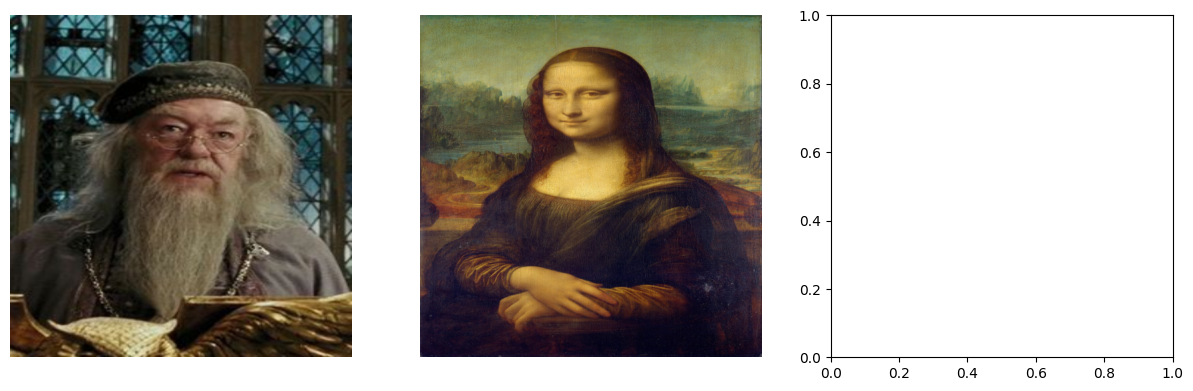

In [ ]:
content_image_url = 'https://upload.wikimedia.org/wikipedia/en/e/e8/Dumbledore_-_Prisoner_of_Azkaban.jpg'
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/1024px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'
content_image = load_image(content_image_url)
style_image = load_image(style_image_url)

# Create input image as a clone of content image
input_image = content_image.clone()

# Transfer style
model, content_losses, style_losses = get_model_and_losses(content_image, style_image)
output = run_style_transfer(model, content_losses, style_losses, input_image, epochs=300, lr=0.03)

Visualize results

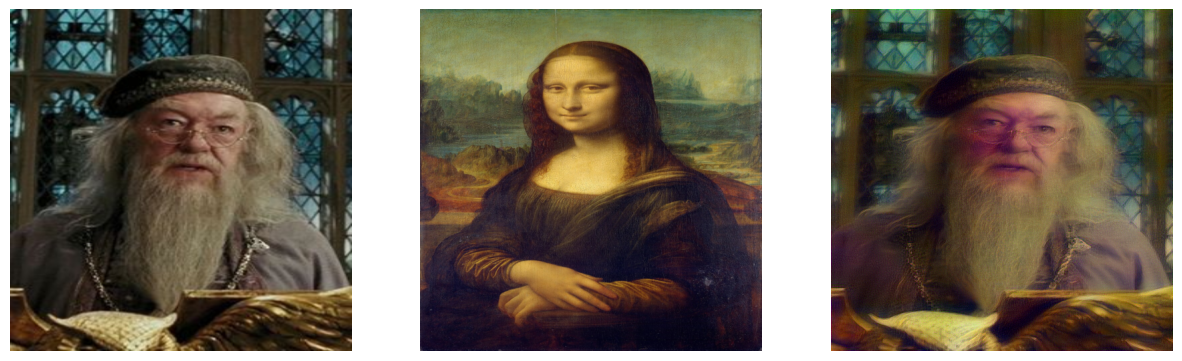

In [ ]:
def visualize_images(content, style, output):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, image in enumerate([content, style, output]):
        ax[i].imshow(image.detach().squeeze(0).permute(1, 2, 0).clamp(0, 1))
        ax[i].axis('off')
    plt.show()

visualize_images(content_image, style_image, output)

Summary of the Code: Deep Art Visualization

    This code implements Neural Style Transfer (NST) using PyTorch.
    The objective of NST is to combine the content of one image with the style of another, producing an artistic image.

Summary of the Neural Style Transfer Pipeline

    Load content & style images.

    Extract deep features from a VGG-19 network.

    Compute content loss using MSE between feature maps.

    Compute style loss using Gram matrices.

    Optimize the input image by adjusting pixel values.

    Generate and visualize the final artistic output.